### Try-it 9.2: Predicting Wages

This activity is meant to summarize your work with regularized regression models.  You will use your earlier work with data preparation and pipelines together with what you've learned with grid searches to determine an optimal model.  In addition to the prior strategies, this example is an excellent opportunity to utilize the `TransformedTargetRegressor` estimator in scikitlearn.

### The Data

This dataset is loaded from the openml resource library.  Originally from census data, the data contains wage and demographic information on 534 individuals. From the dataset documentation [here](https://www.openml.org/d/534)

```
The Current Population Survey (CPS) is used to supplement census information between census years. These data consist of a random sample of 534 persons from the CPS, with information on wages and other characteristics of the workers, including sex, number of years of education, years of work experience, occupational status, region of residence and union membership. 
```

In [1]:
import ssl
from sklearn import set_config

In [2]:
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
set_config(display="diagram")

In [4]:
from sklearn.datasets import fetch_openml

In [5]:
wages = fetch_openml(data_id=534, as_frame=True)

In [6]:
wages.frame.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8.0,no,female,21.0,not_member,5.10,35.0,Hispanic,Other,Manufacturing,Married
1,9.0,no,female,42.0,not_member,4.95,57.0,White,Other,Manufacturing,Married
2,12.0,no,male,1.0,not_member,6.67,19.0,White,Other,Manufacturing,Unmarried
3,12.0,no,male,4.0,not_member,4.00,22.0,White,Other,Other,Unmarried
4,12.0,no,male,17.0,not_member,7.50,35.0,White,Other,Other,Married


#### Task

Build regression models to predict `WAGE`.  Incorporate the categorical features and transform the target using a logarithm.  Build `Ridge` models and consider some different amounts of regularization.  

After fitting your model, interpret the model and try to understand what features led to higher wages.  Consider using `permutation_importance` that you encountered in module 8.  Discuss your findings in the class forum.

For an in depth example discussing the perils of interpreting the coefficients see the example in scikitlearn examples [here](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html).

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import set_config
import seaborn as sns
import numpy as np
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import warnings

In [8]:
# OneHotEncoder
# StandardScaler
# permutation importance / vif
# grid searches

In [9]:
set_config(display="diagram")

In [10]:
w = wages.frame

In [11]:
w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    float64 
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    float64 
 4   UNION       534 non-null    category
 5   WAGE        534 non-null    float64 
 6   AGE         534 non-null    float64 
 7   RACE        534 non-null    category
 8   OCCUPATION  534 non-null    category
 9   SECTOR      534 non-null    category
 10  MARR        534 non-null    category
dtypes: category(7), float64(4)
memory usage: 21.4 KB


In [12]:
w.describe(include="all")

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
count,534.000000,534,534,534.000000,534,534.000000,534.000000,534,534,534,534
unique,NaN,2,2,NaN,2,NaN,NaN,3,6,3,2
top,NaN,no,male,NaN,not_member,NaN,NaN,White,Other,Other,Married
freq,NaN,378,289,NaN,438,NaN,NaN,440,156,411,350
mean,13.018727,NaN,NaN,17.822097,NaN,9.024064,36.833333,NaN,NaN,NaN,NaN
std,2.615373,NaN,NaN,12.379710,NaN,5.139097,11.726573,NaN,NaN,NaN,NaN
min,2.000000,NaN,NaN,0.000000,NaN,1.000000,18.000000,NaN,NaN,NaN,NaN
25%,12.000000,NaN,NaN,8.000000,NaN,5.250000,28.000000,NaN,NaN,NaN,NaN
50%,12.000000,NaN,NaN,15.000000,NaN,7.780000,35.000000,NaN,NaN,NaN,NaN
75%,15.000000,NaN,NaN,26.000000,NaN,11.250000,44.000000,NaN,NaN,NaN,NaN


In [13]:
w.groupby(['SEX','OCCUPATION']).agg(['min','max','median','mean','count'])['WAGE']

min    max  median       mean  count
SEX    OCCUPATION                                         
female Clerical      3.00  15.03   7.000   7.404211     76
       Management    3.64  44.50  10.000  11.056190     21
       Other         3.00  18.50   4.975   5.731333     30
       Professional  4.35  24.98  10.000  11.105000     52
       Sales         3.35  14.29   4.550   5.241765     17
       Service       1.75  13.12   5.000   6.059388     49
male   Clerical      3.35  12.00   7.690   7.489048     21
       Management    1.00  26.29  13.990  13.721765     34
       Other         2.85  26.00   8.500   9.068175    126
       Professional  5.00  24.98  12.000  12.773962     53
       Sales         3.50  19.98   9.420   9.495714     21
       Service       2.01  25.00   5.890   7.226471     34

In [14]:
w.groupby('SEX').median()

,EDUCATION,EXPERIENCE,WAGE,AGE
SEX,,,,
female,12.0,16.0,6.80,35.0
male,12.0,14.0,8.93,34.0


In [15]:
w.columns

Index(['EDUCATION', 'SOUTH', 'SEX', 'EXPERIENCE', 'UNION', 'WAGE', 'AGE',
       'RACE', 'OCCUPATION', 'SECTOR', 'MARR'],
      dtype='object')

In [16]:
'SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'

('SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR')

In [17]:
# yes/no - 1,0
w.SOUTH.value_counts()

no     378
yes    156
Name: SOUTH, dtype: int64

In [18]:
# male/female - 1,0
w.SEX.value_counts()

male      289
female    245
Name: SEX, dtype: int64

In [19]:
# member / nonmember - 1,0
w.UNION.value_counts()

not_member    438
member         96
Name: UNION, dtype: int64

In [20]:
w.RACE.value_counts()

White       440
Other        67
Hispanic     27
Name: RACE, dtype: int64

In [21]:
w.OCCUPATION.value_counts()

Other           156
Professional    105
Clerical         97
Service          83
Management       55
Sales            38
Name: OCCUPATION, dtype: int64

In [22]:
# 
w.SECTOR.value_counts()

Other            411
Manufacturing     99
Construction      24
Name: SECTOR, dtype: int64

In [23]:
# Married/Unmarried - 1,0
w.MARR.value_counts()

Married      350
Unmarried    184
Name: MARR, dtype: int64

In [24]:
X, y = w.drop(columns='WAGE'), w['WAGE']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 93, test_size = 0.3)

array([[<AxesSubplot:title={'center':'EDUCATION'}>,
        <AxesSubplot:title={'center':'EXPERIENCE'}>],
       [<AxesSubplot:title={'center':'AGE'}>, <AxesSubplot:>]],
      dtype=object)

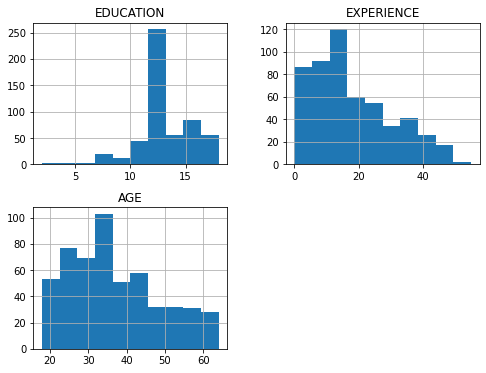

In [25]:
X.hist(figsize = (8, 6))

array([[<AxesSubplot:title={'center':'EXPERIENCE'}>]], dtype=object)

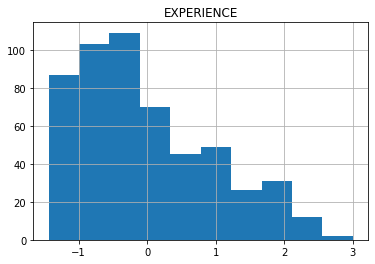

In [84]:
#scale [['EXPERIENCE']]
((X[['EXPERIENCE']] - X[['EXPERIENCE']].mean())/X[['EXPERIENCE']].std()).hist()

<AxesSubplot:>

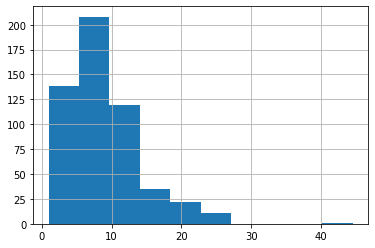

In [26]:
y.hist()

<AxesSubplot:>

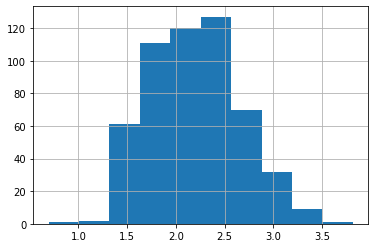

In [27]:
# test out logarithm on target column - transform target!
np.log1p(y).hist()

<AxesSubplot:>

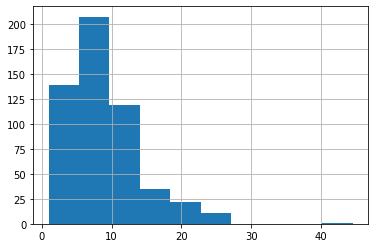

In [28]:
# test out logarithm on target column - inverse transform target!
np.expm1(np.log1p(y)).hist()

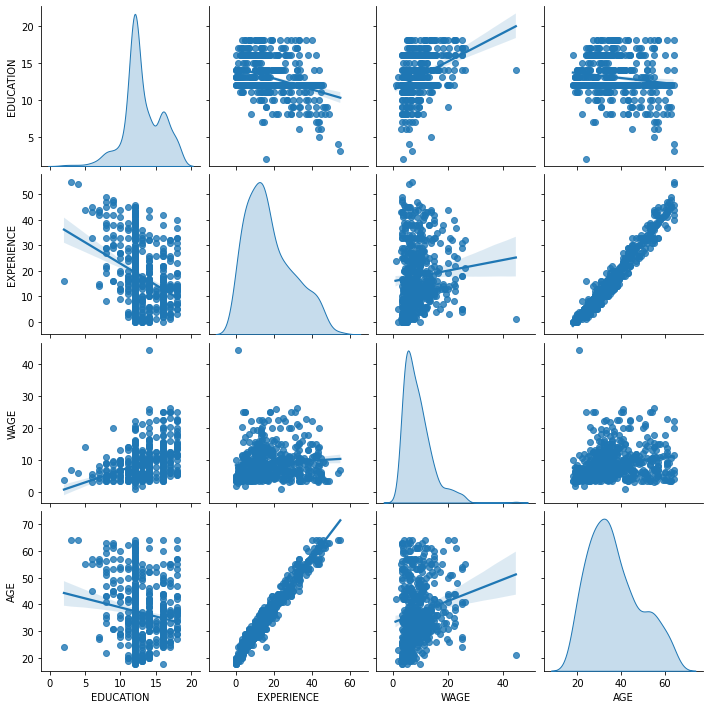

In [29]:
sns.pairplot(w, kind="reg", diag_kind="kde")

### Feature Transformation

In [30]:
# Instantiate OneHotEncoder for tranform features
ohe = OneHotEncoder(sparse = False, drop='if_binary')
print(ohe.fit_transform(w[['MARR','SOUTH', 'SEX', 'UNION', 'SECTOR']])[:5])

[[0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1. 0.]
 [1. 0. 1. 1. 0. 1. 0.]
 [1. 0. 1. 1. 0. 0. 1.]
 [0. 0. 1. 1. 0. 0. 1.]]


In [31]:
#ohe.get_feature_names_out(['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'])

array([[<AxesSubplot:title={'center':'EDUCATION'}>,
        <AxesSubplot:title={'center':'EXPERIENCE'}>,
        <AxesSubplot:title={'center':'WAGE'}>,
        <AxesSubplot:title={'center':'AGE'}>],
       [<AxesSubplot:title={'center':'SOUTH_yes'}>,
        <AxesSubplot:title={'center':'SEX_male'}>,
        <AxesSubplot:title={'center':'UNION_not_member'}>,
        <AxesSubplot:title={'center':'RACE_Hispanic'}>],
       [<AxesSubplot:title={'center':'RACE_Other'}>,
        <AxesSubplot:title={'center':'RACE_White'}>,
        <AxesSubplot:title={'center':'OCCUPATION_Clerical'}>,
        <AxesSubplot:title={'center':'OCCUPATION_Management'}>],
       [<AxesSubplot:title={'center':'OCCUPATION_Other'}>,
        <AxesSubplot:title={'center':'OCCUPATION_Professional'}>,
        <AxesSubplot:title={'center':'OCCUPATION_Sales'}>,
        <AxesSubplot:title={'center':'OCCUPATION_Service'}>],
       [<AxesSubplot:title={'center':'SECTOR_Construction'}>,
        <AxesSubplot:title={'center':'SEC

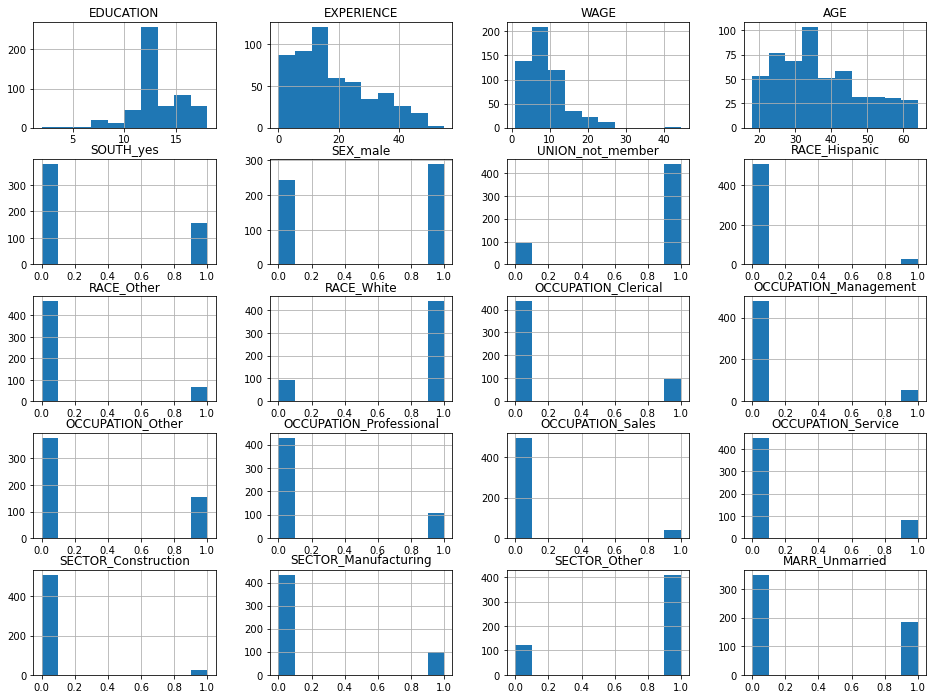

In [32]:
# tranform features and plot histogram
pd.concat([
    w.select_dtypes(include=np.number),
    pd.DataFrame(ohe.fit_transform(X[['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR']]),
             columns=ohe.get_feature_names_out())
]).hist(figsize = (16, 12))

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

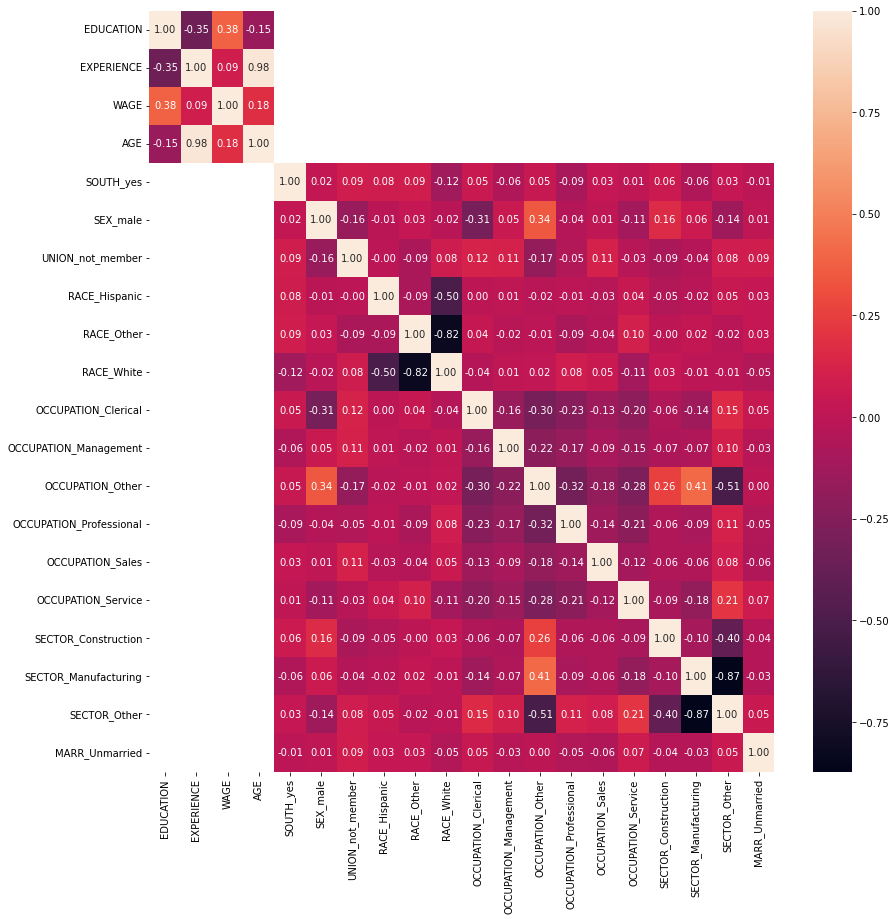

In [33]:
# correlation
# tranform features and plot histogram
plt.tight_layout()
plt.subplots(figsize=(14,14))
sns.heatmap(
    pd.concat([
        w.select_dtypes(include=np.number),
        pd.DataFrame(ohe.fit_transform(X[['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR']]),
                 columns=ohe.get_feature_names_out())
    ]).corr(),
annot=True, fmt='.2f')


In [34]:
# sns.pairplot(pd.concat([
#         w.select_dtypes(include=np.number),
#         pd.DataFrame(ohe.fit_transform(X[['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR']]),
#                  columns=ohe.get_feature_names_out())
#     ]),
#              kind="reg", diag_kind="kde")

In [35]:
# ohe_step = make_column_transformer( (OneHotEncoder(drop = 'if_binary'),
#                                      ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR']), 
#                                      remainder='passthrough')
# #                                  (PolynomialFeatures(include_bias = False, degree = 2), ['OverallQual']) )
# pipe = Pipeline([('transformer', ohe_step), 
#                   ('linreg', LinearRegression())])

### Decide on model complexity

In [36]:
complexity = 8
train_mses = []
test_mses = []
features = [c for c in ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'] if c in X_train.columns]
for d in range(1, complexity):
    #create pipeline with PolynomialFeatures degree d 
    ohe_step = make_column_transformer((OneHotEncoder(drop = 'if_binary'), features),
                                       remainder="passthrough" )
    
    pipe = Pipeline([('transformer', ohe_step),
                     ('polyfeatures', PolynomialFeatures(degree = d, include_bias = False)),
                     ('scaler', StandardScaler()),
                     ('linreg', LinearRegression())])
    #fit on train
    pipe.fit(X_train, y_train)
    #compute mean squared errors
    #predict on train and test
    train_mses.append(mean_squared_error(y_train, pipe.predict(X_train)))
    test_mses.append(mean_squared_error(y_test, pipe.predict(X_test)))
# Answer check
print(pipe.named_steps)
print(train_mses)
print(test_mses)
print(pipe.score(X_test, y_test))
pipe

{'transformer': ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary'),
                                 ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION',
                                  'SECTOR', 'MARR'])]), 'polyfeatures': PolynomialFeatures(degree=7, include_bias=False), 'scaler': StandardScaler(), 'linreg': LinearRegression()}
[16.50384914359465, 12.288816073398023, 4.816789965037928, 16.834296244103324, 3.8124661280025696, 6.689402178310783, 542.0502451886371]
[21.70242928810854, 1.2143673230411745e+27, 4.8329103570816566e+24, 1.368415430772772e+26, 2.7100971341900468e+26, 2.4844812712473285e+26, 5.954853084169979e+26]
-2.071785024342446e+25


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['SOUTH', 'SEX', 'UNION',
                                                   'RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR'])])),
                ('polyfeatures',
                 PolynomialFeatures(degree=7, include_bias=False)),
                ('scaler', StandardScaler()), ('linreg', LinearRegression())])

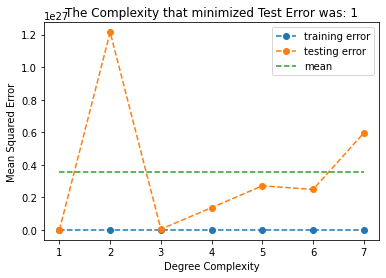

In [37]:
# check effectiveness of complexity!
plt.plot(range(1, complexity), train_mses, '--o', label = 'training error')
plt.plot(range(1, complexity), test_mses, '--o', label = 'testing error')
plt.plot(range(1, complexity), [np.mean(test_mses)]*(complexity-1), '--', label = 'mean')
plt.xticks(range(1, complexity), range(1, complexity))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.title(f'The Complexity that minimized Test Error was: {test_mses.index(min(test_mses)) + 1}')
plt.legend()

In [38]:
# grid = GridSearchCV(pipe, cv=5, param_grid='')
# grid.fit(X,y)

In [39]:
#create pipeline with PolynomialFeatures degree 1
features = [c for c in ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'] if c in X_train.columns]
ohe_step = make_column_transformer((OneHotEncoder(drop = 'if_binary'), features), remainder="passthrough" )

pipe = Pipeline([('transformer', ohe_step),
                 ('scaler', StandardScaler()),
                 ('ttregressor', TransformedTargetRegressor(func=np.log1p,
                                                            inverse_func=np.expm1,
                                                            regressor=LinearRegression())) ])
#fit on train
pipe.fit(X_train, y_train)

# Results
print(pipe.named_steps)
print('Score:', pipe.score(X_test, y_test))
pipe

{'transformer': ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary'),
                                 ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION',
                                  'SECTOR', 'MARR'])]), 'scaler': StandardScaler(), 'ttregressor': TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=LinearRegression())}
Score: 0.2292287145373867


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['SOUTH', 'SEX', 'UNION',
                                                   'RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR'])])),
                ('scaler', StandardScaler()),
                ('ttregressor',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=LinearRegression()))])

In [40]:
# SFS
# Lasso
# Ridge

### Ridge Magnitude of Regularization

In [41]:
# Ridge
#create pipeline with PolynomialFeatures degree 1
# Find best aplha for Ridge regressor
alphas = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 1.0, 10.0, 100.0, 1000.0]
coef_list = []
train_mses = []
test_mses = []
train_maes = []
test_maes = []
train_scores = []
test_scores = []

for a in alphas:
    features = [c for c in ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'] if c in X_train.columns]
    ohe_step = make_column_transformer((OneHotEncoder(drop = 'if_binary'), features), remainder="passthrough" )

    pipe = Pipeline([('transformer', ohe_step),
#                     ('scaler', StandardScaler()),
                     ('ttregressor', TransformedTargetRegressor(func=np.log1p,
                                                                inverse_func=np.expm1,
                                                                regressor=Ridge(alpha = a))) ])
    #fit on train
    pipe.fit(X_train, y_train)
    coef_list.append(list(pipe.named_steps['ttregressor'].regressor_.coef_))
    train_mses.append(mean_squared_error(y_train, pipe.predict(X_train)))
    test_mses.append(mean_squared_error(y_test, pipe.predict(X_test)))
    train_maes.append(mean_absolute_error(y_train, pipe.predict(X_train)))
    test_maes.append(mean_absolute_error(y_test, pipe.predict(X_test)))
    train_scores.append(pipe.score(X_train, y_train))
    test_scores.append(pipe.score(X_test, y_test))
    print('Score:', pipe.score(X_test, y_test))

# Results
print(len(coef_list))
print('Best alpha:', alphas[test_mses.index(min(test_mses))], 'coefficients:' )
print(list(zip(pipe.named_steps['transformer'].get_feature_names_out(), coef_list[test_mses.index(min(test_mses))])))

pipe

Score: 0.22923826384702328
Score: 0.2292382633153629
Score: 0.22923825799880482
Score: 0.2292382048324565
Score: 0.2292376730940262
Score: 0.22923234823014105
Score: 0.22857798941268437
Score: 0.22101249969713255
Score: 0.1799926756181356
Score: 0.12076272507773356
10
Best alpha: 1e-07 coefficients:
[('onehotencoder__SOUTH_yes', -0.06387578146723814), ('onehotencoder__SEX_male', 0.174919182446364), ('onehotencoder__UNION_not_member', -0.15498660564434655), ('onehotencoder__RACE_Hispanic', 0.036772933199798935), ('onehotencoder__RACE_Other', -0.05073411068434553), ('onehotencoder__RACE_White', 0.013961073552168718), ('onehotencoder__OCCUPATION_Clerical', 0.0159394397275827), ('onehotencoder__OCCUPATION_Management', 0.12433367538554513), ('onehotencoder__OCCUPATION_Other', -0.014389232933581372), ('onehotencoder__OCCUPATION_Professional', 0.10313435241179869), ('onehotencoder__OCCUPATION_Sales', -0.13925244484966115), ('onehotencoder__OCCUPATION_Service', -0.08976562920982209), ('onehote

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['SOUTH', 'SEX', 'UNION',
                                                   'RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR'])])),
                ('ttregressor',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=Ridge(alpha=1000.0)))])

In [42]:
# Ridge
# GridSearchCV
# Find best alpha for Ridge regressor
alphas = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 1.0, 10.0, 100.0, 1000.0]
features = [c for c in ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'] if c in X_train.columns]
ohe_step = make_column_transformer((OneHotEncoder(drop = 'if_binary'), features), remainder="passthrough" )
pipe = Pipeline([('transformer', ohe_step),
#                     ('scaler', StandardScaler()),
                 ('ttregressor', TransformedTargetRegressor(func=np.log1p,
                                                            inverse_func=np.expm1,
                                                            regressor=Ridge(alpha = a))) ])
param_dict = {'ttregressor__regressor__alpha':
              [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 1.0, 10.0, 100.0, 1000.0]}
grid = GridSearchCV(pipe, param_grid=param_dict)
#fit on train
grid.fit(X_train, y_train)
train_mse = mean_squared_error(y_train, grid.predict(X_train))
test_mse = mean_squared_error(y_test, grid.predict(X_test))
best_alpha = grid.best_params_
print('Best Alpha:', best_alpha)
print('Score:', grid.score(X_test, y_test))
print('Train MSE:', train_mse)
print('Test MSE :',test_mse)
# Results

Best Alpha: {'ttregressor__regressor__alpha': 10.0}
Score: 0.22101249969713255
Train MSE: 17.30254348200956
Test MSE : 22.390142144118766


In [43]:
#pipe.named_steps('ttregressor__Ridge').coef_

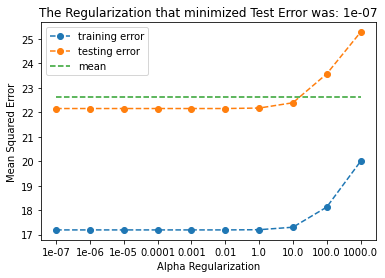

In [44]:
# check effectiveness of regularization!
complexity = 11
plt.plot(range(1, complexity), train_mses, '--o', label = 'training error')
plt.plot(range(1, complexity), test_mses, '--o', label = 'testing error')
plt.plot(range(1, complexity), [np.mean(test_mses)]*(complexity-1), '--', label = 'mean')
plt.xticks(range(1, complexity), [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 1.0, 10.0, 100.0, 1000.0])
plt.xlabel('Alpha Regularization')
plt.ylabel('Mean Squared Error')
plt.title(f'The Regularization that minimized Test Error was: {alphas[test_mses.index(min(test_mses))]}')
plt.legend()

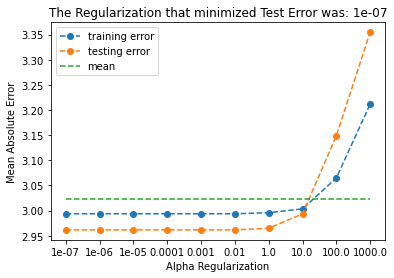

In [45]:
# check effectiveness of complexity!
complexity = 11
plt.plot(range(1, complexity), train_maes, '--o', label = 'training error')
plt.plot(range(1, complexity), test_maes, '--o', label = 'testing error')
plt.plot(range(1, complexity), [np.mean(test_maes)]*(complexity-1), '--', label = 'mean')
plt.xticks(range(1, complexity), [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 1.0, 10.0, 100.0, 1000.0])
plt.xlabel('Alpha Regularization')
plt.ylabel('Mean Absolute Error')
plt.title(f'The Regularization that minimized Test Error was: {alphas[test_maes.index(min(test_maes))]}')
plt.legend()

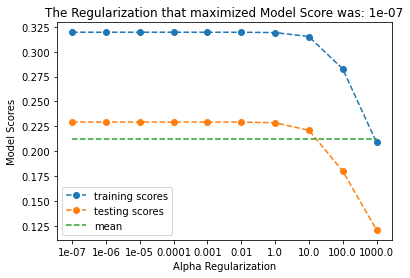

In [46]:
# check effectiveness of complexity!
complexity = 11
plt.plot(range(1, complexity), train_scores, '--o', label = 'training scores')
plt.plot(range(1, complexity), test_scores, '--o', label = 'testing scores')
plt.plot(range(1, complexity), [np.mean(test_scores)]*(complexity-1), '--', label = 'mean')
plt.xticks(range(1, complexity), [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 1.0, 10.0, 100.0, 1000.0])
plt.xlabel('Alpha Regularization')
plt.ylabel('Model Scores')
plt.title(f'The Regularization that maximized Model Score was: {alphas[test_scores.index(max(test_scores))]}')
plt.legend()

In [47]:
# Best Ridge as baseline!
features = [c for c in ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'] if c in X_train.columns]
ohe_step = make_column_transformer((OneHotEncoder(drop = 'if_binary'), features), remainder="passthrough" )

pipe = Pipeline([('transformer', ohe_step),
#                 ('scaler', StandardScaler()),
                 ('ttr_ridge', TransformedTargetRegressor(func=np.log1p,
                                                            inverse_func=np.expm1,
                                                            regressor=Ridge(alpha = 0.0000001))) ])
#fit on train
pipe.fit(X_train, y_train)
#    n_step = pipe.named_steps('ttregressor')
print('Train MSE:', mean_squared_error(y_train, pipe.predict(X_train)))
print('Test MSE :', mean_squared_error(y_test, pipe.predict(X_test)))
print('Score    :', pipe.score(X_test, y_test))
list(zip(pipe.named_steps['transformer'].get_feature_names_out(), list(pipe.named_steps['ttr_ridge'].regressor_.coef_)))

Train MSE: 17.192462996285165
Test MSE : 22.15371212632202
Score    : 0.22923826384702328


[('onehotencoder__SOUTH_yes', -0.06387578146723814),
 ('onehotencoder__SEX_male', 0.174919182446364),
 ('onehotencoder__UNION_not_member', -0.15498660564434655),
 ('onehotencoder__RACE_Hispanic', 0.036772933199798935),
 ('onehotencoder__RACE_Other', -0.05073411068434553),
 ('onehotencoder__RACE_White', 0.013961073552168718),
 ('onehotencoder__OCCUPATION_Clerical', 0.0159394397275827),
 ('onehotencoder__OCCUPATION_Management', 0.12433367538554513),
 ('onehotencoder__OCCUPATION_Other', -0.014389232933581372),
 ('onehotencoder__OCCUPATION_Professional', 0.10313435241179869),
 ('onehotencoder__OCCUPATION_Sales', -0.13925244484966115),
 ('onehotencoder__OCCUPATION_Service', -0.08976562920982209),
 ('onehotencoder__SECTOR_Construction', -0.04430375800073762),
 ('onehotencoder__SECTOR_Manufacturing', 0.07815916570968164),
 ('onehotencoder__SECTOR_Other', -0.03385538001360888),
 ('onehotencoder__MARR_Unmarried', -0.08946901342280586),
 ('remainder__EDUCATION', 0.13075171365772406),
 ('remainde

In [48]:
# Lasso
features = [c for c in ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'] if c in X_train.columns]
ohe_step = make_column_transformer((OneHotEncoder(drop = 'if_binary'), features), remainder="passthrough" )

pipe = Pipeline([('transformer', ohe_step),
                 ('polyfeatures', PolynomialFeatures(degree = 3)),
                 ('scaler', StandardScaler()),
                 ('ttregressor', TransformedTargetRegressor(func=np.log1p,
                                                            inverse_func=np.expm1,
                                                            regressor=Lasso(alpha = 0.01, random_state = 93))) ])
#fit on train
pipe.fit(X_train, y_train)
#    n_step = pipe.named_steps('ttregressor')
#    coef_list.append(list(pipe.named_steps('ttregressor').coef_))
print('Train MSE:', mean_squared_error(y_train, pipe.predict(X_train)))
print('Test MSE :', mean_squared_error(y_test, pipe.predict(X_test)))
print('Score    :', pipe.score(X_test, y_test))

Train MSE: 12.8764803936509
Test MSE : 23.51536106719622
Score    : 0.18186440181818142


In [49]:
# Lasso w/o TTR
features = [c for c in ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'] if c in X_train.columns]
ohe_step = make_column_transformer((OneHotEncoder(drop = 'if_binary'), features), remainder="passthrough" )

alphas = [0.001, 0.01, 1.0, 10.0, 100.0, 1000.0]
for a in alphas:
    pipe = Pipeline([('transformer', ohe_step),
                     ('scaler', StandardScaler()),
                     ('lasso', Lasso(alpha = a, max_iter=1000, random_state = 93))
                    ])
    #fit on train
    pipe.fit(X_train, y_train)
    #    n_step = pipe.named_steps('ttregressor')
    #    coef_list.append(list(pipe.named_steps('ttregressor').coef_))
    print('Train MSE:', mean_squared_error(y_train, pipe.predict(X_train)))
    print('Test MSE :', mean_squared_error(y_test, pipe.predict(X_test)))
    print('Score    :', pipe.score(X_test, y_test))
pipe
#pipe.named_steps['polyfeatures'].get_feature_names_out()
#ohe_step.get_feature_names_out()

Train MSE: 16.501771770966602
Test MSE : 21.673927210739325
Score    : 0.2459307193779927
Train MSE: 16.506135529885395
Test MSE : 21.64978455913411
Score    : 0.2467706793792993
Train MSE: 21.20703264574378
Test MSE : 25.902414974711593
Score    : 0.09881512305368612
Train MSE: 25.27044847443739
Test MSE : 28.94944732926933
Score    : -0.007195821492387955
Train MSE: 25.27044847443739
Test MSE : 28.94944732926933
Score    : -0.007195821492387955
Train MSE: 25.27044847443739
Test MSE : 28.94944732926933
Score    : -0.007195821492387955


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['SOUTH', 'SEX', 'UNION',
                                                   'RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR'])])),
                ('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=1000.0, random_state=93))])

In [50]:
# Best Lasso w/o TTR
features = [c for c in ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'] if c in X_train.columns]
ohe_step = make_column_transformer((OneHotEncoder(drop = 'if_binary'), features), remainder="passthrough" )

pipe = Pipeline([('transformer', ohe_step),
                 ('scaler', StandardScaler()),
                 ('lasso', Lasso(alpha = 0.001, max_iter=1000, random_state = 93))
                ])
#fit on train
pipe.fit(X_train, y_train)
#    n_step = pipe.named_steps('ttregressor')
#    coef_list.append(list(pipe.named_steps('ttregressor').coef_))
print('Train MSE:', mean_squared_error(y_train, pipe.predict(X_train)))
print('Test MSE :', mean_squared_error(y_test, pipe.predict(X_test)))
print('Score    :', pipe.score(X_test, y_test))
pd.DataFrame({'feature': ohe_step.get_feature_names_out(), 'coef': pipe.named_steps['lasso'].coef_})

Train MSE: 16.501771770966602
Test MSE : 21.673927210739325
Score    : 0.2459307193779927


,feature,coef
0,onehotencoder__SOUTH_yes,-0.231970
1,onehotencoder__SEX_male,1.045550
2,onehotencoder__UNION_not_member,-0.492210
3,onehotencoder__RACE_Hispanic,0.114732
4,onehotencoder__RACE_Other,-0.245677
5,onehotencoder__RACE_White,0.000000
6,onehotencoder__OCCUPATION_Clerical,0.000000
7,onehotencoder__OCCUPATION_Management,0.585185
8,onehotencoder__OCCUPATION_Other,-0.007110
9,onehotencoder__OCCUPATION_Professional,0.538939


In [51]:
# vif
def vif(data):
    columns = data.columns
    vif_dict = {}

    for col in data.select_dtypes(include=np.number).columns:
        exclude_col = [i for i in columns if i!=col]
        X,y = data[exclude_col], data[col]

        features = [c for c in ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'] if c in data.columns]
        ohe_step = make_column_transformer((OneHotEncoder(drop = 'if_binary'), features), remainder="passthrough" )
        # fit model with training set
        pipe = Pipeline([('transformer', ohe_step),
                         ('scaler', StandardScaler()),
                         ('ttr_ridge', TransformedTargetRegressor(func=np.log1p,
                                                                    inverse_func=np.expm1,
                                                                    regressor=Ridge(alpha = 0.0000001))) ])
        # vif = 1 / (1- R^2)
        r_squared = pipe.fit(X, y).score(X, y)
        if r_squared == 1:
            vif = 0
        else:
            vif = 1 / (1-r_squared)
        vif_dict[col] = vif

    df_vif = pd.DataFrame({"VIF":vif_dict}).sort_values(by = "VIF", ascending = False)
    return df_vif

In [52]:
features = [c for c in ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'] if c in X.columns]

In [53]:
X.select_dtypes(include=np.number).columns

Index(['EDUCATION', 'EXPERIENCE', 'AGE'], dtype='object')

In [54]:
# permutation importance
#function to execute permutation importance!
def column_importance(X, y):
    features = [c for c in ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'] if c in X.columns]
    ohe_step = make_column_transformer((OneHotEncoder(drop = 'if_binary'), features), remainder="passthrough" )

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 93, train_size=0.7, test_size=0.3)
    # fit model with training set
    pipe = Pipeline([('transformer', ohe_step),
#                     ('scaler', StandardScaler()),
                     ('ttr_ridge', TransformedTargetRegressor(func=np.log1p,
                                                                inverse_func=np.expm1,
                                                                regressor=Ridge(alpha = 0.0000001))) ])
    model = pipe.fit(X_train, y_train)
    # score with test set
    print('model r^2 :', model.score(X_test, y_test))
    # permutation importance
    r = permutation_importance(model, X_test, y_test, n_repeats = 50, random_state = 93)
    print('importance:', r.importances_mean)
    return model, X_test, y_test, pd.DataFrame({"Column":X.columns, "Importance":r.importances_mean}).sort_values(
        by = "Importance", ascending = False)

In [55]:
model, Xp_test, yp_test, ranking = column_importance(X, y)
ranking

model r^2 : 0.22923826384702328
importance: [ 9.52680733e-01  1.04150893e-02  6.38366206e-02  3.35964783e+01
  2.82918634e-02  1.41267230e+01  2.50403214e-03  7.96072003e-02
  6.33716623e-03 -9.81998560e-03]


,Column,Importance
3,EXPERIENCE,33.596478
5,AGE,14.126723
0,EDUCATION,0.952681
7,OCCUPATION,0.079607
2,SEX,0.063837
4,UNION,0.028292
1,SOUTH,0.010415
8,SECTOR,0.006337
6,RACE,0.002504
9,MARR,-0.009820


In [56]:
Xsub = X.drop(columns=['MARR', 'RACE', 'SECTOR'])
model, Xp_test, yp_test, ranking = column_importance(Xsub, y)
ranking

model r^2 : 0.2519851397459888
importance: [0.63960862 0.01134658 0.05794541 8.8739924  0.02839879 3.56143213
 0.09226629]


,Column,Importance
3,EXPERIENCE,8.873992
5,AGE,3.561432
0,EDUCATION,0.639609
6,OCCUPATION,0.092266
2,SEX,0.057945
4,UNION,0.028399
1,SOUTH,0.011347


In [57]:
# Xsub = X.drop(columns=['SECTOR', 'RACE', 'MARR'])
# model, Xp_test, yp_test, ranking = column_importance(Xsub, y)
# ranking

In [58]:
# Check multicollinearity
#Variance inflation Factor (VIF) to determine Multicollinearity in a dataset
vif(w)

,VIF
AGE,36.990614
EDUCATION,28.809585
EXPERIENCE,2.609430
WAGE,1.423259


In [59]:
vif(w[['EDUCATION', 'EXPERIENCE', 'WAGE']])

,VIF
EDUCATION,1.353049
WAGE,1.214623
EXPERIENCE,1.035579


In [60]:
Xsub = X.drop(columns=['MARR', 'RACE', 'SECTOR', 'AGE'])
model, Xp_test, yp_test, ranking = column_importance(Xsub, y)
ranking

model r^2 : 0.252259532508016
importance: [0.24130691 0.01141195 0.05748824 0.09976709 0.0283189  0.09261415]


,Column,Importance
0,EDUCATION,0.241307
3,EXPERIENCE,0.099767
5,OCCUPATION,0.092614
2,SEX,0.057488
4,UNION,0.028319
1,SOUTH,0.011412


In [61]:
# Xsub after permutation importance!
X_train, X_test, y_train, y_test = train_test_split(Xsub, y, random_state = 93, train_size=0.7, test_size=0.3)
features = [c for c in ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'] if c in Xsub.columns]

In [62]:
# Ridge
#create pipeline with PolynomialFeatures degree 1
# Find best aplha for Ridge regressor
alphas = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 1.0, 10.0, 100.0, 1000.0]
coef_list = []
train_mses = []
test_mses = []
train_scores = []
test_scores = []

for a in alphas:
    ohe_step = make_column_transformer((OneHotEncoder(drop = 'if_binary'), features), remainder="passthrough" )
    pipe = Pipeline([('transformer', ohe_step),
#                     ('scaler', StandardScaler()),
                     ('ttregressor', TransformedTargetRegressor(func=np.log1p,
                                                                inverse_func=np.expm1,
                                                                regressor=Ridge(alpha = a))) ])
    #fit on train
    pipe.fit(X_train, y_train)
    train_mses.append(mean_squared_error(y_train, pipe.predict(X_train)))
    test_mses.append(mean_squared_error(y_test, pipe.predict(X_test)))
    coef_list.append(list(pipe.named_steps['ttregressor'].regressor_.coef_))
    train_scores.append(pipe.score(X_train, y_train))
    test_scores.append(pipe.score(X_test, y_test))
    print('Score:', pipe.score(X_test, y_test))

# Results
print(len(coef_list))
print('Best alpha:', alphas[test_mses.index(min(test_mses))], 'coefficients:',
        list(zip(pipe.named_steps['transformer'].get_feature_names_out(), coef_list[test_mses.index(min(test_mses))]))
     )

# # Results
# print(pipe.named_steps)
pipe

Score: 0.252259532508016
Score: 0.25225953112744526
Score: 0.25225951732173846
Score: 0.25225937926484276
Score: 0.2522579987130604
Score: 0.252244194912402
Score: 0.25074485434327287
Score: 0.23875487503212978
Score: 0.18581770961764987
Score: 0.11429043678934625
10
Best alpha: 1e-07 coefficients: [('onehotencoder__SOUTH_yes', -0.07970190250951435), ('onehotencoder__SEX_male', 0.16589439152331906), ('onehotencoder__UNION_not_member', -0.15602255621070946), ('onehotencoder__OCCUPATION_Clerical', -0.0006228846159696958), ('onehotencoder__OCCUPATION_Management', 0.1299574357167849), ('onehotencoder__OCCUPATION_Other', 0.013231822053930935), ('onehotencoder__OCCUPATION_Professional', 0.11358732714203484), ('onehotencoder__OCCUPATION_Sales', -0.13395426405788066), ('onehotencoder__OCCUPATION_Service', -0.12219899717073451), ('remainder__EDUCATION', 0.07106077716653499), ('remainder__EXPERIENCE', 0.010437022020205414)]


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['SOUTH', 'SEX', 'UNION',
                                                   'OCCUPATION'])])),
                ('ttregressor',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=Ridge(alpha=1000.0)))])

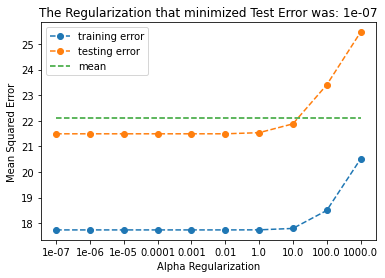

In [63]:
# check effectiveness of regularization!
complexity = 11
plt.plot(range(1, complexity), train_mses, '--o', label = 'training error')
plt.plot(range(1, complexity), test_mses, '--o', label = 'testing error')
plt.plot(range(1, complexity), [np.mean(test_mses)]*(complexity-1), '--', label = 'mean')
plt.xticks(range(1, complexity), [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 1.0, 10.0, 100.0, 1000.0])
plt.xlabel('Alpha Regularization')
plt.ylabel('Mean Squared Error')
plt.title(f'The Regularization that minimized Test Error was: {alphas[test_mses.index(min(test_mses))]}')
plt.legend()

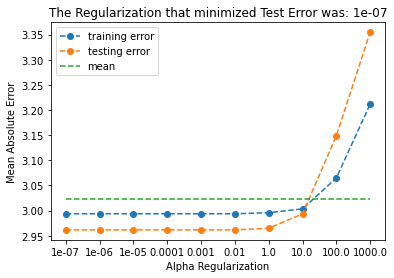

In [64]:
# check effectiveness of complexity!
complexity = 11
plt.plot(range(1, complexity), train_maes, '--o', label = 'training error')
plt.plot(range(1, complexity), test_maes, '--o', label = 'testing error')
plt.plot(range(1, complexity), [np.mean(test_maes)]*(complexity-1), '--', label = 'mean')
plt.xticks(range(1, complexity), [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 1.0, 10.0, 100.0, 1000.0])
plt.xlabel('Alpha Regularization')
plt.ylabel('Mean Absolute Error')
plt.title(f'The Regularization that minimized Test Error was: {alphas[test_maes.index(min(test_maes))]}')
plt.legend()

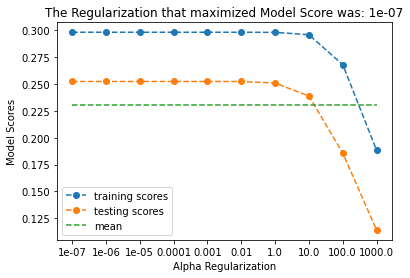

In [65]:
# check effectiveness of complexity!
complexity = 11
plt.plot(range(1, complexity), train_scores, '--o', label = 'training scores')
plt.plot(range(1, complexity), test_scores, '--o', label = 'testing scores')
plt.plot(range(1, complexity), [np.mean(test_scores)]*(complexity-1), '--', label = 'mean')
plt.xticks(range(1, complexity), [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 1.0, 10.0, 100.0, 1000.0])
plt.xlabel('Alpha Regularization')
plt.ylabel('Model Scores')
plt.title(f'The Regularization that maximized Model Score was: {alphas[test_scores.index(max(test_scores))]}')
plt.legend()

#### Ridge model with GridSearchCV

In [86]:
# Ridge
# 
# Find best alpha for Ridge regressor
alphas = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 1.0, 10.0, 100.0, 1000.0]
ohe_step = make_column_transformer((OneHotEncoder(drop = 'if_binary'), features), remainder="passthrough" )
pipe = Pipeline([('transformer', ohe_step),
#                     ('scaler', StandardScaler()),
                 ('ttregressor', TransformedTargetRegressor(func=np.log1p,
                                                            inverse_func=np.expm1,
                                                            regressor=Ridge(alpha = a))) ])
param_dict = {'ttregressor__regressor__alpha':
              [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 1.0, 10.0, 100.0, 1000.0]}
#grid = GridSearchCV(pipe, param_grid=param_dict, scoring = 'neg_mean_squared_error')
grid = GridSearchCV(pipe, param_grid=param_dict)
#fit on train
grid.fit(X_train, y_train)
train_mse = mean_squared_error(y_train, grid.predict(X_train))
test_mse = mean_squared_error(y_test, grid.predict(X_test))
best_alpha = grid.best_params_
print('Best Alpha:', best_alpha)
print('Score:', grid.score(X_test, y_test))
# Results

Best Alpha: {'ttregressor__regressor__alpha': 10.0}
Score: 0.23875487503212978


In [67]:
grid.cv_results_

{'mean_fit_time': array([0.00460858, 0.0041873 , 0.00411444, 0.00402679, 0.00431471,
        0.0075561 , 0.0049262 , 0.00409818, 0.00448089, 0.00398335]),
 'std_fit_time': array([8.30297737e-04, 2.57619870e-04, 1.64163365e-04, 5.41323805e-05,
        4.52051193e-04, 9.64303773e-04, 1.07099734e-03, 1.54088362e-04,
        3.92236676e-04, 6.93952242e-05]),
 'mean_score_time': array([0.0023232 , 0.0022953 , 0.00223494, 0.00221763, 0.00278959,
        0.00389557, 0.00252757, 0.00228467, 0.00227933, 0.00239415]),
 'std_score_time': array([8.33729556e-05, 1.64124094e-04, 1.32743021e-04, 3.53579174e-05,
        1.22205429e-03, 3.40509625e-04, 2.47376831e-04, 1.80718741e-04,
        1.06908061e-04, 1.90089170e-04]),
 'param_ttregressor__regressor__alpha': masked_array(data=[1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 1.0, 10.0,
                    100.0, 1000.0],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',

In [68]:
grid.best_score_

0.24994637676336545

In [69]:
X_test[:1], y_test[:1]

(     EDUCATION SOUTH   SEX  EXPERIENCE       UNION OCCUPATION
 271       18.0   yes  male        10.0  not_member   Clerical,
 271    5.21
 Name: WAGE, dtype: float64)

In [70]:
grid.predict(X_test[:1]), y_test[:1]

(array([10.80145345]),
 271    5.21
 Name: WAGE, dtype: float64)

In [71]:
# Best Ridge as baseline!
features = [c for c in ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'] if c in X_train.columns]
ohe_step = make_column_transformer((OneHotEncoder(drop = 'if_binary'), features), remainder="passthrough" )

pipe = Pipeline([('transformer', ohe_step),
#                 ('scaler', StandardScaler()),
                 ('ttr_ridge', TransformedTargetRegressor(func=np.log1p,
                                                            inverse_func=np.expm1,
                                                            regressor=Ridge(alpha = 10))) ])
#fit on train
pipe.fit(X_train, y_train)
print('Train MSE:', mean_squared_error(y_train, pipe.predict(X_train)))
print('Test MSE :', mean_squared_error(y_test, pipe.predict(X_test)))
print('Train MAE:', mean_absolute_error(y_train, pipe.predict(X_train)))
print('Test MAE :', mean_absolute_error(y_test, pipe.predict(X_test)))
print('Score    :', pipe.score(X_test, y_test))


Train MSE: 17.797252395784014
Test MSE : 21.88017978198787
Train MAE: 3.0588058708473724
Test MAE : 2.980551928177486
Score    : 0.23875487503212978


In [72]:
pipe.predict(X_test[:1]), y_test[:1]

(array([10.80145345]),
 271    5.21
 Name: WAGE, dtype: float64)

In [73]:
feature_names = pipe.named_steps['transformer'].get_feature_names_out()
feature_names

array(['onehotencoder__SOUTH_yes', 'onehotencoder__SEX_male',
       'onehotencoder__UNION_not_member',
       'onehotencoder__OCCUPATION_Clerical',
       'onehotencoder__OCCUPATION_Management',
       'onehotencoder__OCCUPATION_Other',
       'onehotencoder__OCCUPATION_Professional',
       'onehotencoder__OCCUPATION_Sales',
       'onehotencoder__OCCUPATION_Service', 'remainder__EDUCATION',
       'remainder__EXPERIENCE'], dtype=object)

In [74]:
coefs = pd.DataFrame(
    pipe.named_steps['ttr_ridge'].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)
coefs

,Coefficients
onehotencoder__SOUTH_yes,-0.070789
onehotencoder__SEX_male,0.149940
onehotencoder__UNION_not_member,-0.133828
onehotencoder__OCCUPATION_Clerical,-0.007648
onehotencoder__OCCUPATION_Management,0.094232
onehotencoder__OCCUPATION_Other,0.021128
onehotencoder__OCCUPATION_Professional,0.093289
onehotencoder__OCCUPATION_Sales,-0.098670
onehotencoder__OCCUPATION_Service,-0.102332
remainder__EDUCATION,0.074716


In [75]:
coefs.sort_values(by = "Coefficients", ascending = False)

,Coefficients
onehotencoder__SEX_male,0.149940
onehotencoder__OCCUPATION_Management,0.094232
onehotencoder__OCCUPATION_Professional,0.093289
remainder__EDUCATION,0.074716
onehotencoder__OCCUPATION_Other,0.021128
remainder__EXPERIENCE,0.010619
onehotencoder__OCCUPATION_Clerical,-0.007648
onehotencoder__SOUTH_yes,-0.070789
onehotencoder__OCCUPATION_Sales,-0.098670
onehotencoder__OCCUPATION_Service,-0.102332


Text(0.5, 0, 'Coefficient values')

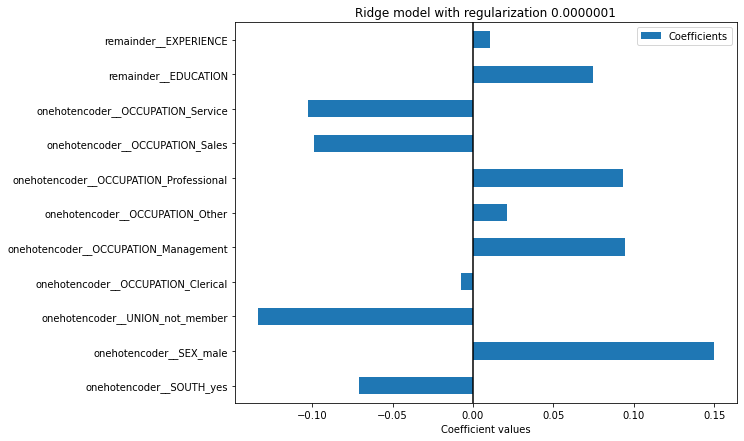

In [76]:
# plot coefficients
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model with regularization 0.0000001")
plt.axvline(x=0, color="black")
plt.xlabel("Coefficient values")

In [77]:
#np.logspace(0, 10, 50)

In [78]:
pipe.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('onehotencoder',
                                    OneHotEncoder(drop='if_binary'),
                                    ['SOUTH', 'SEX', 'UNION', 'OCCUPATION'])])),
  ('ttr_ridge',
   TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                              regressor=Ridge(alpha=10)))],
 'verbose': False,
 'transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('onehotencoder',
                                  OneHotEncoder(drop='if_binary'),
                                  ['SOUTH', 'SEX', 'UNION', 'OCCUPATION'])]),
 'ttr_ridge': TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                            regressor=Ridge(alpha=10)),
 'transformer__n_jobs': None,
 'transformer__remainder': 'passthrough',
 'transformer__sparse_threshold': 0.3,
 'transformer__

### Lasso Model

In [79]:
features = [c for c in ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'] if c in X_train.columns]
ohe_step = make_column_transformer((OneHotEncoder(drop = 'if_binary'), features), remainder="passthrough" )
lasso_pipe = Pipeline([('transformer', ohe_step),
                       ('poly_features', PolynomialFeatures(degree = 1, include_bias = False)),
                       ('scaler', StandardScaler()),
                       ('selector', SelectFromModel(Lasso())),
                       ('ttr_linear', TransformedTargetRegressor(func=np.log1p,
                                                            inverse_func=np.expm1,
                                                            regressor=LinearRegression()))
                      ])
lasso_pipe.fit(X_train, y_train)
lasso_train_mse = mean_squared_error(y_train, lasso_pipe.predict(X_train))
lasso_test_mse = mean_squared_error(y_test, lasso_pipe.predict(X_test))
lasso_train_mae = mean_absolute_error(y_train, lasso_pipe.predict(X_train))
lasso_test_mae = mean_absolute_error(y_test, lasso_pipe.predict(X_test))

print('Train MSE: ', lasso_train_mse)
print('Test MSE : ', lasso_test_mse)
print('Train MAE: ', lasso_train_mae)
print('Test MAE : ', lasso_test_mae)
print('Score    :', lasso_pipe.score(X_test, y_test))


Train MSE:  20.56696226394055
Test MSE :  25.151612109735836
Train MAE:  3.3330362768312725
Test MAE :  3.385493464008414
Score    : 0.12493671010048057


In [80]:
coef_list = []
train_mses = []
test_mses = []
train_scores = []
test_scores = []

complexity = 6
for d in range(1, complexity):
    features = [c for c in ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'] if c in X_train.columns]
    ohe_step = make_column_transformer((OneHotEncoder(drop = 'if_binary'), features), remainder="passthrough" )
    lasso_pipe = Pipeline([('transformer', ohe_step),
                           ('poly_features', PolynomialFeatures(degree = d, include_bias = False)),
                           ('scaler', StandardScaler()),
                           ('selector', SelectFromModel(Lasso())),
                           ('ttr_linear', TransformedTargetRegressor(func=np.log1p,
                                                                inverse_func=np.expm1,
                                                                regressor=LinearRegression()))
                          ])
    #fit on train
    lasso_pipe.fit(X_train, y_train)
    train_mses.append(mean_squared_error(y_train, lasso_pipe.predict(X_train)))
    test_mses.append(mean_squared_error(y_test, lasso_pipe.predict(X_test)))
    coef_list.append(list(lasso_pipe.named_steps['ttr_linear'].regressor_.coef_))
    train_scores.append(lasso_pipe.score(X_train, y_train))
    test_scores.append(lasso_pipe.score(X_test, y_test))
    print('Score@' + str(d) + ':', lasso_pipe.score(X_test, y_test))

# Results
print(len(coef_list))
print('Best complexity:', test_mses.index(min(test_mses))+1, 'coefficients:',
        list(zip(lasso_pipe.named_steps['transformer'].get_feature_names_out(),
                 coef_list[test_mses.index(min(test_mses))]))
     )

Score@1: 0.12493671010048057
Score@2: 0.18196002763633767
Score@3: 0.18730676093262544
Score@4: 0.1785716876963631
Score@5: 0.19346219256084118
5
Best complexity: 5 coefficients: [('onehotencoder__SOUTH_yes', 0.2265668192104138), ('onehotencoder__SEX_male', -0.10253062957021696), ('onehotencoder__UNION_not_member', 0.048291859225288246), ('onehotencoder__OCCUPATION_Clerical', 0.06597526878244983), ('onehotencoder__OCCUPATION_Management', 0.048291859225288246), ('onehotencoder__OCCUPATION_Other', 0.04050922751274986)]


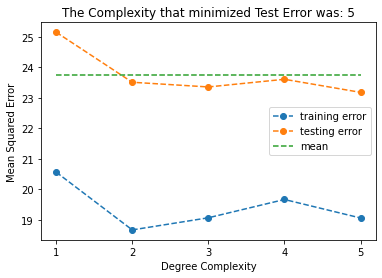

In [81]:
# check effectiveness of complexity!
plt.plot(range(1, complexity), train_mses, '--o', label = 'training error')
plt.plot(range(1, complexity), test_mses, '--o', label = 'testing error')
plt.plot(range(1, complexity), [np.mean(test_mses)]*(complexity-1), '--', label = 'mean')
plt.xticks(range(1, complexity), range(1, complexity))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.title(f'The Complexity that minimized Test Error was: {test_mses.index(min(test_mses)) + 1}')
plt.legend()